In [77]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.layers import Input, BatchNormalization, Dropout, Lambda
from tqdm import tqdm_notebook

In [3]:
train=np.zeros(140)
train_df=pd.DataFrame(train)

In [4]:
train_df.columns=(["index"])
for i in range(0,len(train_df)):
    train_df.iloc[i,0]=int(i)

In [5]:
from tqdm import tqdm
add=os.listdir("I:\\小組雲端硬碟\\影像辨識專題-自己小組\\圖片檔\\seg_要用的\\original\\");
add_='I:\\小組雲端硬碟\\影像辨識專題-自己小組\\圖片檔\\seg_要用的\\original\\'
maskadd=os.listdir("I:\\小組雲端硬碟\\影像辨識專題-自己小組\\圖片檔\\seg_要用的\\mask\\");
path1='I:\\小組雲端硬碟\\影像辨識專題-自己小組\\圖片檔\\seg_要用的\\mask\\'

In [6]:
train_df["address"]=None
for j in range(0,len(train_df)):
    train_df.iloc[j,1]=os.path.join(add_+add[j])



In [7]:
train_df["label"]=None

In [31]:
Y_train.shape

(140, 512, 512, 1)

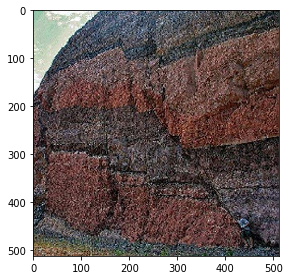

In [29]:
imshow(X_train[1]/255)
plt.show()#squeeze(Y_train[ix])

In [8]:
for j in range(0,len(train_df)):
    train_df.iloc[j,2]=os.path.join(path1+add[j])

In [85]:
im_height=im_width=256
im_chan=3
X_train = np.zeros((len(add), im_height, im_width, im_chan), dtype=np.float)
Y_train = np.zeros((len(add), im_height, im_width, 1), dtype=np.bool)

In [86]:
for n, id_ in tqdm(enumerate(add), total=len(add)):
    path = add_
    img = load_img(path  + id_)
    x = img_to_array(img)[:,:,:im_chan]
    x = resize(x, (256, 256,3), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path1  + id_))[:,:,1]
    Y_train[n] = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)

print('Done!')

100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:10<00:00, 18.80it/s]


Done!


In [58]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

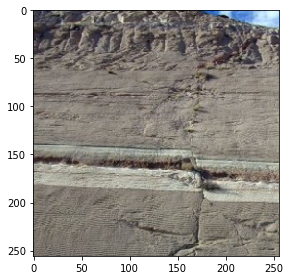

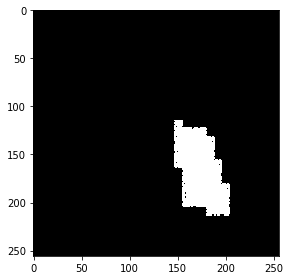

In [88]:
ix = random.randint(0, len(add))
imshow(X_train[ix]/255)
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [175]:
inputs = Input((im_height, im_width, im_chan))
#s = Lambda(lambda x: x/255 ) (inputs)
s = BatchNormalization()(inputs)
s = Dropout(0.5)(s)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])

In [154]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



In [176]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)

In [177]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=8, epochs=40, 
                    
                    callbacks=[earlystopper, checkpointer]
                   )

Train on 155 samples, validate on 39 samples
Epoch 1/40
155/155 [==============================] - ETA: 3:42 - loss: 1.3760 - acc: 0.623 - ETA: 2:41 - loss: 1.4172 - acc: 0.686 - ETA: 2:16 - loss: 1.4005 - acc: 0.684 - ETA: 2:02 - loss: 1.3892 - acc: 0.676 - ETA: 1:50 - loss: 1.3787 - acc: 0.670 - ETA: 1:39 - loss: 1.3743 - acc: 0.673 - ETA: 1:29 - loss: 1.3708 - acc: 0.679 - ETA: 1:20 - loss: 1.3694 - acc: 0.690 - ETA: 1:12 - loss: 1.3691 - acc: 0.694 - ETA: 1:04 - loss: 1.3633 - acc: 0.695 - ETA: 57s - loss: 1.3599 - acc: 0.700 - ETA: 49s - loss: 1.3570 - acc: 0.70 - ETA: 42s - loss: 1.3538 - acc: 0.70 - ETA: 35s - loss: 1.3519 - acc: 0.71 - ETA: 29s - loss: 1.3495 - acc: 0.71 - ETA: 22s - loss: 1.3474 - acc: 0.72 - ETA: 15s - loss: 1.3462 - acc: 0.72 - ETA: 9s - loss: 1.3444 - acc: 0.7250 - ETA: 2s - loss: 1.3427 - acc: 0.726 - 139s 895ms/step - loss: 1.3425 - acc: 0.7254 - val_loss: 1.3618 - val_acc: 0.8467

Epoch 00001: val_loss improved from inf to 1.36177, saving model to model-

155/155 [==============================] - ETA: 1:53 - loss: 1.0153 - acc: 0.739 - ETA: 1:50 - loss: 0.9998 - acc: 0.747 - ETA: 1:45 - loss: 0.9869 - acc: 0.757 - ETA: 1:40 - loss: 0.9353 - acc: 0.784 - ETA: 1:34 - loss: 0.9378 - acc: 0.786 - ETA: 1:29 - loss: 0.9333 - acc: 0.786 - ETA: 1:23 - loss: 0.9541 - acc: 0.777 - ETA: 1:16 - loss: 0.9429 - acc: 0.783 - ETA: 1:09 - loss: 0.9207 - acc: 0.790 - ETA: 1:02 - loss: 0.9055 - acc: 0.796 - ETA: 55s - loss: 0.9176 - acc: 0.797 - ETA: 48s - loss: 0.9171 - acc: 0.79 - ETA: 41s - loss: 0.9293 - acc: 0.79 - ETA: 35s - loss: 0.9325 - acc: 0.79 - ETA: 28s - loss: 0.9322 - acc: 0.79 - ETA: 21s - loss: 0.9343 - acc: 0.79 - ETA: 15s - loss: 0.9340 - acc: 0.79 - ETA: 8s - loss: 0.9364 - acc: 0.7958 - ETA: 2s - loss: 0.9348 - acc: 0.795 - 136s 875ms/step - loss: 0.9317 - acc: 0.7960 - val_loss: 1.0243 - val_acc: 0.8483

Epoch 00017: val_loss improved from 1.05595 to 1.02432, saving model to model-tgs-salt-1.h5
Epoch 18/40
155/155 [=================

155/155 [==============================] - ETA: 1:51 - loss: 0.5333 - acc: 0.900 - ETA: 1:45 - loss: 0.5905 - acc: 0.888 - ETA: 1:38 - loss: 0.5983 - acc: 0.888 - ETA: 1:32 - loss: 0.6084 - acc: 0.885 - ETA: 1:26 - loss: 0.6129 - acc: 0.882 - ETA: 1:20 - loss: 0.6442 - acc: 0.876 - ETA: 1:14 - loss: 0.6360 - acc: 0.879 - ETA: 1:08 - loss: 0.6574 - acc: 0.874 - ETA: 1:02 - loss: 0.6531 - acc: 0.874 - ETA: 56s - loss: 0.6577 - acc: 0.874 - ETA: 50s - loss: 0.6880 - acc: 0.86 - ETA: 44s - loss: 0.6906 - acc: 0.86 - ETA: 38s - loss: 0.6833 - acc: 0.86 - ETA: 32s - loss: 0.6866 - acc: 0.86 - ETA: 26s - loss: 0.6852 - acc: 0.86 - ETA: 20s - loss: 0.6832 - acc: 0.86 - ETA: 14s - loss: 0.6857 - acc: 0.86 - ETA: 8s - loss: 0.6911 - acc: 0.8665 - ETA: 2s - loss: 0.6834 - acc: 0.867 - 127s 820ms/step - loss: 0.6846 - acc: 0.8672 - val_loss: 1.0255 - val_acc: 0.8035

Epoch 00033: val_loss did not improve from 0.98624
Epoch 00033: early stopping


In [80]:
import pickle
from sklearn.externals import joblib
filename = "D:\\桌面\\finalized_model.sav"
pickle.dump(model, open(filename, 'wb'))

#loaded_model = joblib.load("C:\\Users\\USER\\Desktop\\finalized_model.sav")

In [178]:
preds_train = model.predict(X_train[40:160], verbose=1)


120/120 [==============================] - ETA: 27 - ETA: 15 - ETA: 6 - 31s 255ms/step


In [1]:
from keras.models import Model, load_model
model = load_model('model-tgs-salt-1.h5',custom_objects={'bce_dice_loss': bce_dice_loss})

Using TensorFlow backend.


NameError: name 'bce_dice_loss' is not defined

In [179]:
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_train_t = (preds_train > 0.5).astype(np.uint8)

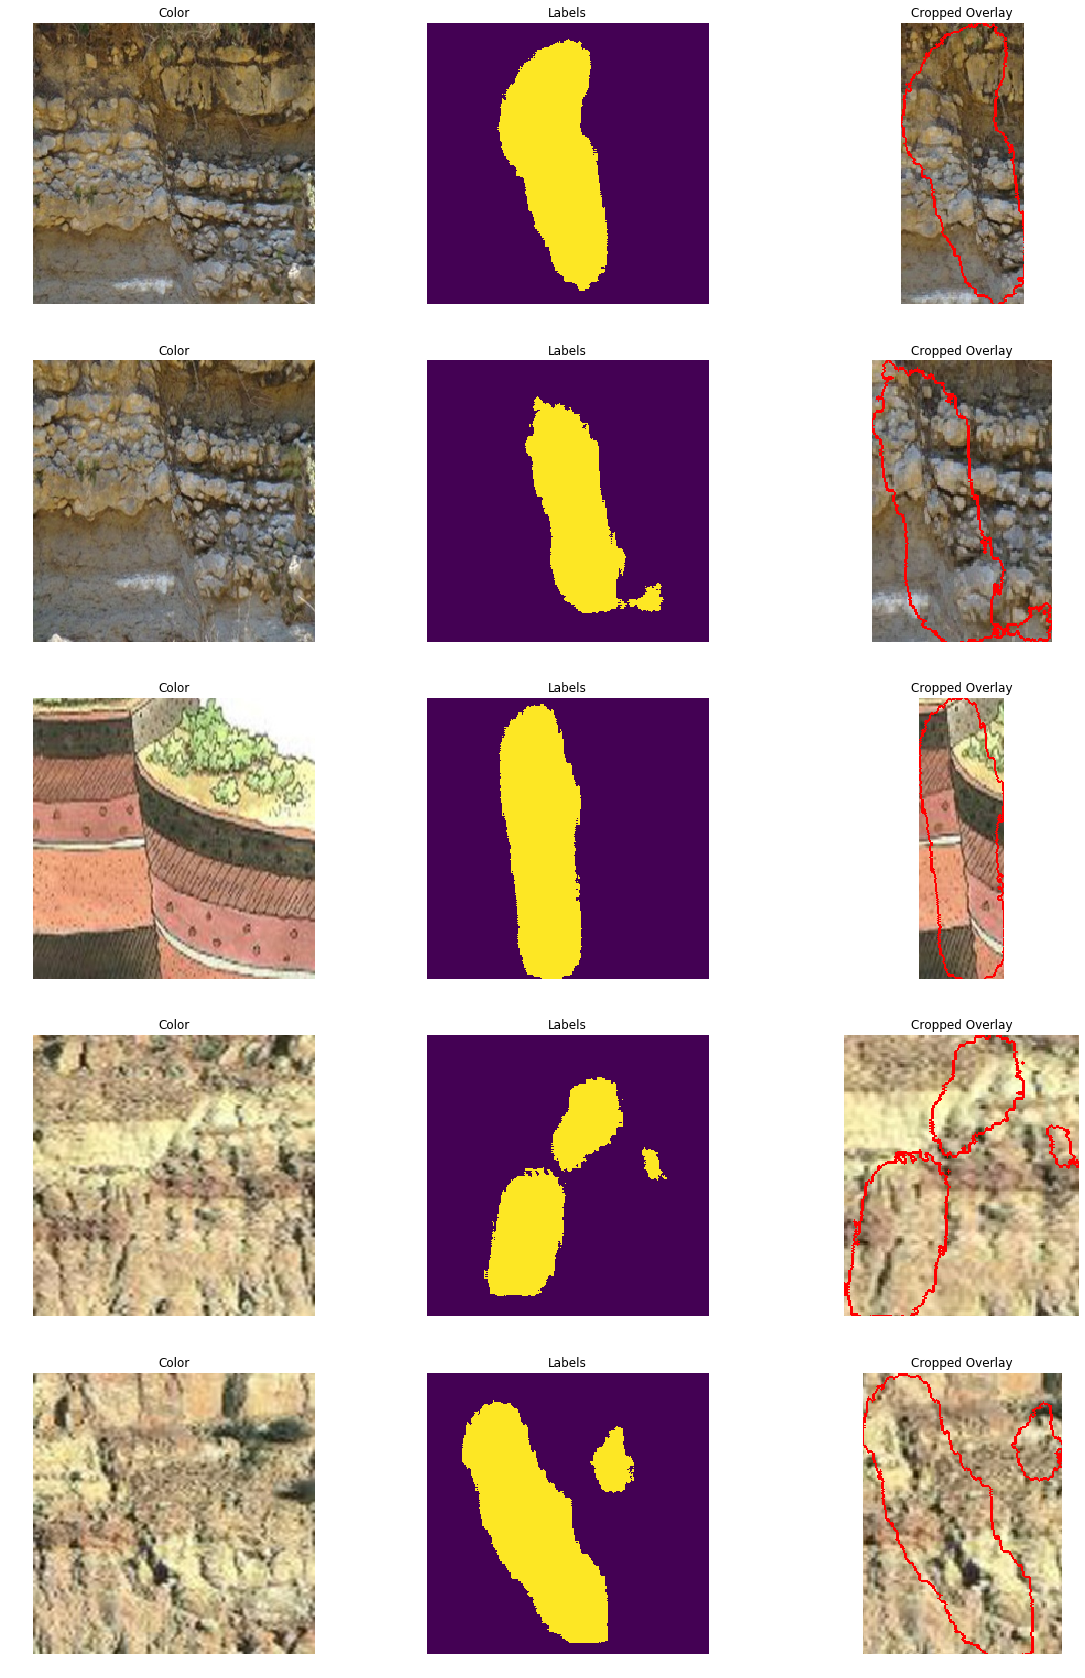

In [188]:
from skimage.segmentation import mark_boundaries
sample_rows = 5
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), rgb_img, lab_img in zip(m_axs,X_train[40:160] ,preds_train_t ):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img[:,:,0], cmap = 'viridis')  #viridis  nipy_spectral
    ax2.set_title('Labels')
    if lab_img.max()>0.1:
        xd, yd = np.where(lab_img[:,:,0]>0)
        bound_img = mark_boundaries(image = r_rgb_img, label_img = lab_img[:,:,0], 
                                    color = (1,0,0), background_label = 255, mode = 'thick')
        ax3.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
        ax3.set_title('Cropped Overlay')